# Hyperparameters tuning (Estimators of the NRDD and its transforms)

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import NuSVR
from lightgbm import LGBMRegressor

In [5]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

ft_pca_path = os.path.join(base_dir, 'Scripts', str(fam) + '-pca-long-displacements.ft')
df_disp_pca = pd.read_feather(ft_pca_path)

In [6]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [ ]:
lst_param = df_params.columns.to_list()

# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [3]:
# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

# Prediction of the Normalized Relative Displacement Deviation of the output displacement

The MLP estimator had the best scores during the benchmark and the cross-validation. In this notebook we will tune their hyperparameters with a Bayesian approach to optimize the precisions.

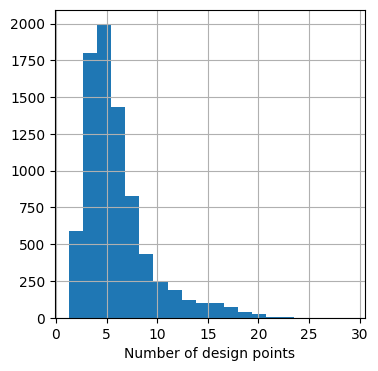

In [ ]:
# Target variable: NRDD
target = 'long_disp_rmsd'
y = df_params[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

### Hyperparameters tuning

Pipeline with the MLPRegressor

In [9]:
preprocessor = ColumnTransformer(
                            transformers=[
                                        ('numerical', StandardScaler(), lst_expl),
                                        ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_mlp = MLPRegressor(max_iter=400, random_state=55)

pipe_start_mlp = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', start_mlp)
                        ])


In [10]:
# Start model
pipe_start_mlp.fit(X_train, y_train)
y_pred_start_mlp = pipe_start_mlp.predict(X_test)

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_mlp = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('mlpregressor', start_mlp)
                ])

params_mlp = {'mlpregressor__hidden_layer_sizes': Integer(80, 500),
                'mlpregressor__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
                'mlpregressor__solver': Categorical(['lbfgs', 'sgd', 'adam']),
                'mlpregressor__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
                'mlpregressor__batch_size': Integer(100, 300),
                'mlpregressor__learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
                'mlpregressor__learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
              }

bayes_search = BayesSearchCV(estimator=pipe_tuned_mlp,
                             search_spaces=params_mlp,
                             n_iter=32,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

In [12]:
# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


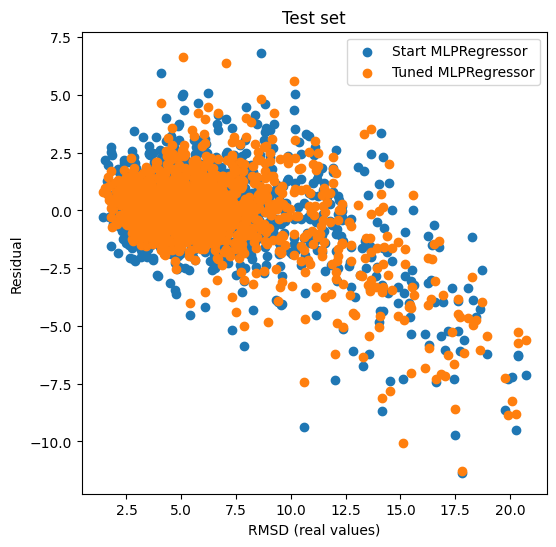

In [ ]:
y_pred_tuned_mlp = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_mlp-y_test, label='Start MLPRegressor')
plt.scatter(y_test, y_pred_tuned_mlp-y_test, label='Tuned MLPRegressor')
plt.xlabel('NRDD (real values)')
plt.ylabel('Residual')
plt.title('Test set')
plt.legend()
plt.show()

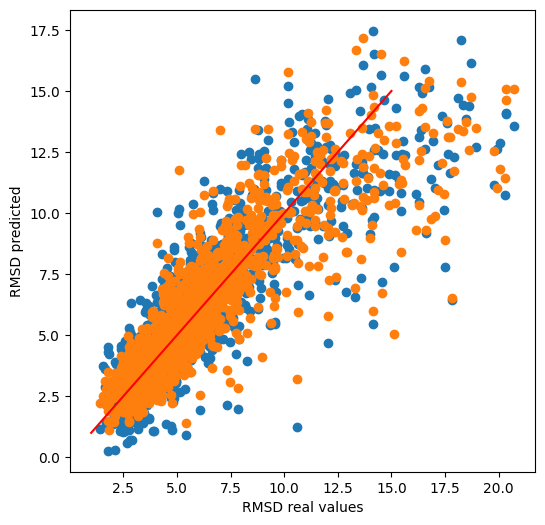

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_mlp, label='Start MLPRegressor')
plt.scatter(y_test, y_pred_tuned_mlp, label='Tuned MLPRegressor')
plt.plot([1, 15], [1, 15], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.show()

# Prediction of the inverse of the NRDD

The NuSVR estimator had the best scores during the benchmark and the cross-validation, contrary to the NRDD itsself. In this notebook we will tune its hyperparameters.

In [ ]:
# Target variable: 1/NRDD
target = 'long_disp_nrdd'
y = 1/df_params[target]

### Hyperparameter tuning of the NuSVR model

In [31]:
preprocessor = ColumnTransformer(
                            transformers=[
                                        ('numerical', StandardScaler(), lst_expl),
                                        ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_nu = NuSVR()

pipe_start_nu = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', start_nu)
                        ])


In [32]:
# Start model
pipe_start_nu.fit(X_train, y_train)
y_pred_start_nu = pipe_start_nu.predict(X_test)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_nu = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('nuregressor', start_nu)
                ])

params_nu = {'nuregressor__nu': Real(0.01, 0.99),
                'nuregressor__C': Real(1e-3, 1e2, prior='log-uniform'),
                'nuregressor__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
                'nuregressor__degree': Integer(3, 6),
                'nuregressor__gamma': Categorical(['scale', 'auto']),
                'nuregressor__coef0': Real(-10.0, 10.0),
                'nuregressor__shrinking': Categorical([True, False])
              }

bayes_search = BayesSearchCV(estimator=pipe_tuned_nu,
                             search_spaces=params_nu,
                             n_iter=32,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

In [38]:
# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

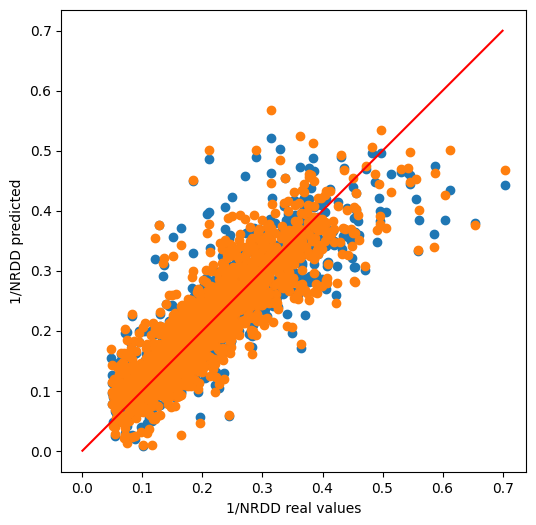

In [40]:
y_pred_tuned_nu = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_nu, label='Start NuSVR Regressor')
plt.scatter(y_test, y_pred_tuned_nu, label='Tuned NuSVR Regressor')
plt.plot([0, 0.7], [0, 0.7], 'r')
plt.xlabel('1/NRDD real values')
plt.ylabel('1/NRDD predicted')
plt.show()

### Hyperparameter tuning of the LightGBM model

In [13]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

start_lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True)

pipe_start_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

In [14]:
# Start model
pipe_start_lgbm.fit(X_train, y_train)
y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.211296


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

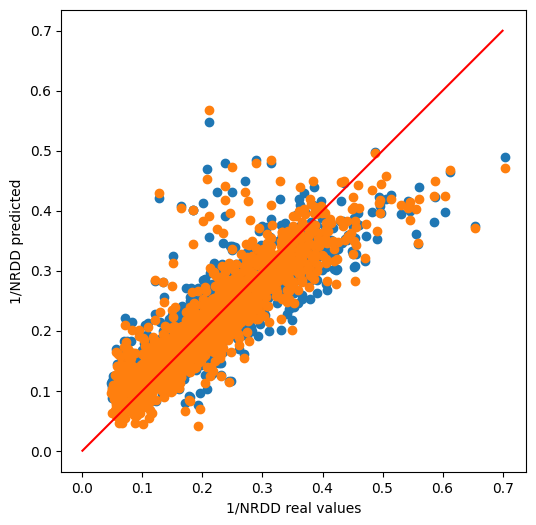

In [16]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

params_lgbm = {'regressor__n_estimators': Integer(100, 15000),
                'regressor__num_leaves': Integer(4, 8),
                'regressor__min_child_samples': Integer(5, 20),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__reg_alpha': Real(1e-5, 1e0, prior='log-uniform'),
                'regressor__reg_lambda': Real(1e-5, 1e0, prior='log-uniform')}

bayes_search = BayesSearchCV(estimator=pipe_tuned_lgbm,
                             search_spaces=params_lgbm,
                             n_iter=256,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)
y_pred_tuned_lgbm = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_lgbm, label='Start LGBM Regressor')
plt.scatter(y_test, y_pred_tuned_lgbm, label='Tuned LGBM Regressor')
plt.plot([0, 0.7], [0, 0.7], 'r')
plt.xlabel('1/NRDD real values')
plt.ylabel('1/NRDD predicted')
plt.show()

### Conclusion

* The NuSVR score is reaching 0.73 after 32 iterations
* The hyperparameter tuning of the LightGBM is even better (0.77) and much less computer-intensive

# Prediction of the transformed NRDD with QuantileTransformer

In [2]:
from sklearn.preprocessing import QuantileTransformer

In [18]:
# Target variable
target = 'long_disp_nrdd'
y = df_params[[target]]

In [19]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

start_lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True)

pipe_start_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

transf = QuantileTransformer()
w = transf.fit_transform(y)

X_train, X_test, w_train, w_test = train_test_split(X, w, test_size = 0.2, random_state=55)

# Start model
pipe_start_lgbm.fit(X_train, w_train)
w_pred_start_lgbm = pipe_start_lgbm.predict(X_test)


[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.500763


c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.500763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

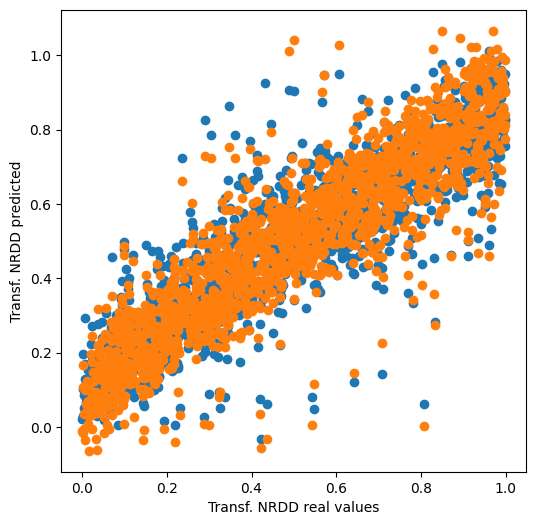

In [20]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

params_lgbm = {'regressor__n_estimators': Integer(100, 15000),
                'regressor__num_leaves': Integer(4, 15),
                'regressor__min_child_samples': Integer(2, 8),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__reg_alpha': Real(1e-3, 1e2, prior='log-uniform'),
                'regressor__reg_lambda': Real(1e-7, 1e-1, prior='log-uniform')}

bayes_search = BayesSearchCV(estimator=pipe_tuned_lgbm,
                             search_spaces=params_lgbm,
                             n_iter=64,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

# Perform the bayesian search
bayes_search.fit(X_train, w_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, w_test))

w_pred_start_lgbm = pipe_start_lgbm.predict(X_test)
w_pred_tuned_lgbm = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(w_test, w_pred_start_lgbm, label='Start LGBM Regressor')
plt.scatter(w_test, w_pred_tuned_lgbm, label='Tuned LGBM Regressor')
#plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('Transf. NRDD real values')
plt.ylabel('Transf. NRDD predicted')
plt.show()

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


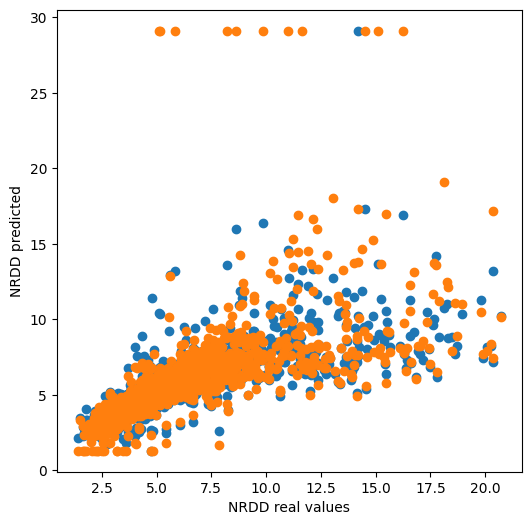

In [27]:
y_test = transf.inverse_transform(w_test)
y_pred_start_lgbm = transf.inverse_transform(pd.DataFrame(w_pred_start_lgbm))
y_pred_tuned_lgbm = transf.inverse_transform(pd.DataFrame(w_pred_tuned_lgbm))

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_lgbm, label='Start LGBM Regressor')
plt.scatter(y_test, y_pred_tuned_lgbm, label='Tuned LGBM Regressor')
#plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.show()

# Dimension reduction and predictions of the first PCA components

In [15]:
df_disp_pca.head()

,disp_long_pca_0,disp_long_pca_1,disp_long_pca_2,disp_long_pca_3,disp_long_pca_4,disp_long_pca_5,disp_long_pca_6,disp_long_pca_7,disp_long_pca_8,disp_long_pca_9
0,0.183473,-0.530461,-0.058382,-0.137153,-0.125449,-0.175369,-0.005078,0.141552,0.056207,0.004686
1,-0.052721,-0.529183,-0.222535,-0.156241,0.127483,-0.141872,0.021843,-0.058946,-0.015004,0.001485
2,0.091780,0.158265,-0.930603,-0.006428,0.045809,0.128306,0.027098,0.019608,-0.012959,0.003315
3,-0.158038,-0.353832,-0.750471,-0.205093,0.174767,0.208255,0.004535,-0.032998,0.001760,0.010116
4,0.262992,0.079327,-0.681280,0.056430,0.093500,0.020183,-0.048230,0.148808,0.035064,0.012742


## First component PCA 0

In [16]:
target = 'disp_long_pca_0'
y = df_disp_pca[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [17]:
preprocessor = ColumnTransformer(
                            transformers=[
                                        ('numerical', StandardScaler(), lst_expl),
                                        ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_extratrees = ExtraTreesRegressor(n_estimators=270, random_state=55, n_jobs=-1)

pipe_start_extratrees = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', start_extratrees)
                        ])

In [18]:
# Start model
pipe_start_extratrees.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['dim_x', 'dim_y', 'dim_z',
                                                   'slot_x_length',
                                                   'slot_x_distance',
                                                   'slot_z_length',
                                                   'slot_z_distance',
                                                   'chamfer_x_dim_y',
                                                   'chamfer_x_dim_z',
                                                   'chamfer_y_dim_x',
                                                   'chamfer_y_dim_z',
                                                   'chamfer_z_dim_x',
                                                   'chamfer_z_dim_y',
                                                   'elefoot_x', 'elefoot_z',
                                                   'cut_x_start', 'cut_x_end',
                                                   'cut_x_depth', 'cut_z_start',
                                                   'cut_z_end', 'cut_z_depth',
                                                   'seg_x_out', 'seg_z_out']),
                                                 ('categorical', 'passthrough',
                                                  ['slot_2-2', 'slot_3-2',
                                                   'slot_4-1', 'slot_4-2'])])),
                ('regressor',
                 ExtraTreesRegressor(n_estimators=270, n_jobs=-1,
                                     random_state=55))])

In [19]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_extratrees = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('etregressor', start_extratrees)
                ])

params_extratrees = {'etregressor__n_estimators': Integer(100, 5000),
                      'etregressor__criterion': Categorical(['squared_error', 'absolute_error', 'friedman_mse']),
                      'etregressor__min_samples_split': Integer(2, 10),
                      'etregressor__min_samples_leaf': Integer(2, 10),
                      'etregressor__min_weight_fraction_leaf': Real(0.0, 0.5),
                      'etregressor__max_features': Categorical(['sqrt', 'log2', None])
}

bayes_search = BayesSearchCV(estimator=pipe_tuned_extratrees,
                             search_spaces=params_extratrees,
                             n_iter=32,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

In [20]:
# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['squared_error', 'sqrt', 2, 2, 0.0, 5000] before, using random point ['absolute_error', 'sqrt', 9, 6, 0.458142643412402, 4474]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.2838703422914951
Best parameters_ OrderedDict([('etregressor__criterion', 'squared_error'), ('etregressor__max_features', None), ('etregressor__min_samples_leaf

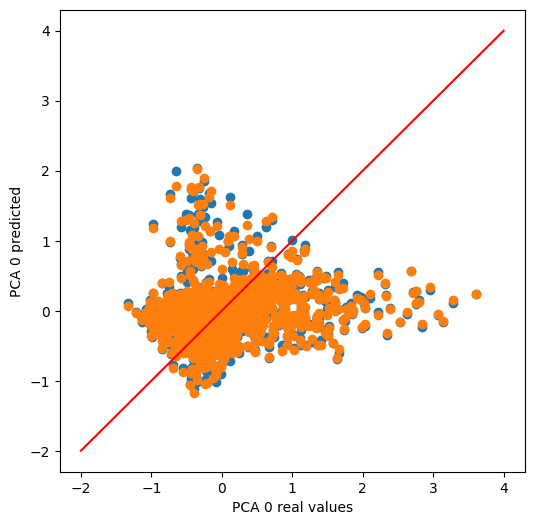

In [23]:
y_pred_start_et = pipe_start_extratrees.predict(X_test)
y_pred_tuned_et = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_et, label='Start MLPRegressor')
plt.scatter(y_test, y_pred_tuned_et, label='Tuned MLPRegressor')
plt.plot([-2, 4], [-2, 4], 'r')
plt.xlabel('PCA 0 real values')
plt.ylabel('PCA 0 predicted')
plt.show()

## Second component PCA 1

The second component is not so clustered as the first component. However a gap seems to be present around the value -1

In [22]:
target = 'disp_long_pca_1'
y = df_disp_pca[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)